# The problem 
An ant leaves its anthill in order to forage for food. It moves with the speed of 10cm per second, but it doesn't know where to go, therefore every second it moves randomly 10cm directly north, south, east or west with equal probability.

1. If the food is located on east-west lines 20cm to the north and 20cm to the south, as well as on north-south lines 20cm to the east and 20cm to the west from the anthill, how long will it take the ant to reach it on average?

2. What is the average time the ant will reach food if it is located only on a diagonal line passing through (10cm, 0cm) and (0cm, 10cm) points?

3. Can you write a program that comes up with an estimate of average time to find food for any closed boundary around the anthill? What would be the answer if food is located outside an defined by $((x – 2.5cm) / 30cm )^{2} + ( (y – 2.5cm) / 40cm )^{2} < 1$ in coordinate system where the anthill is located at (x = 0cm, y = 0cm)?



# Random Walk Background
## One Dimension
### Expectation and Variance
Consider the ant is moving along a straight line (e.g. the x axis). At each time step the ant either moves in the positive or negative x direction with equal probability.
Considering just the first timestep $t^{0}$ it is easy to see that the expectation of the position at $t^{1}$ is given by $E(x^{1}) = \sum_{i}^{1} x_i p_i = 0$, where $x_i \in \{-1, +1\}$ and $p_0 = p_1 = 0.5$. Similarly it can be shown that $var(x^{1}) = 1, \implies \sigma(x^{1}) = 1$.
Now generalising to the nth timestep we have that $E(x^{n}) = \sum_{j=0}^{n} E(x^{j}) = 0$. Using the definition of variance: $var(x) = E(x^{2}) - E(x)^2$ we can see that $var(x^{n}) = n \implies \sigma(x^{n}) = \sqrt{n}$.

In [55]:
# lets check our calculation with a monte carlo simulation

# import
from numpy.random import default_rng
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod
from math import sqrt

# Let's create a base class that 1d and 2d ants can inherit from
class AntBase(metaclass=ABCMeta):
    def __init__(self):
        self.rng = default_rng()
        self.reset_coords()

    @abstractmethod
    def move(self) -> None:
        pass
    
    @abstractmethod
    def at_food(self) -> bool:
        pass

    @abstractmethod
    def reset_coords(self) -> None:
        pass

    def time_to_food(self) -> int:
        """
        Time how long ant takes to get to food
        """
        seconds = 0
        while not self.at_food:
            seconds += 1
            self.move()
        self.reset_coords()
        return seconds


# 1d ant inherits from base
class Ant1D(AntBase):
    def move(self) -> None:
        """
        Move the ant one random step +/- 10 cm along x axis
        """
        self.x += self.rng.choice((-10, +10))

    @property
    def at_food(self) -> bool:
        """
        Determine whether ant is at food or not
        """
        return abs(self.x) >= 20

    def reset_coords(self) -> None:
        """
        Reset ant's position to the origin
        """
        self.x = 0

    @staticmethod
    def sim(num_repeats: int, timesteps: list[int]) -> tuple[list[float]]:
        """ "
        Run num_repeats MC simulations for each time in timesteps
        returns: list of means, variances and standard deviations for each time in timesteps
        """
        ant = Ant1D()
        means = []
        variances = []
        standard_deviations = []
        for t in timesteps:
            positions = []
            for repeat in range(num_repeats):
                for i in range(t):
                    ant.move()
                positions.append(ant.x)
                ant.reset_coords()
            mean = sum(positions) / num_repeats
            means.append(mean)
            variance = sum((mean - i) ** 2 for i in positions) / num_repeats
            variances.append(variance)
            standard_deviations.append(sqrt(variance))
        return means, variances, standard_deviations

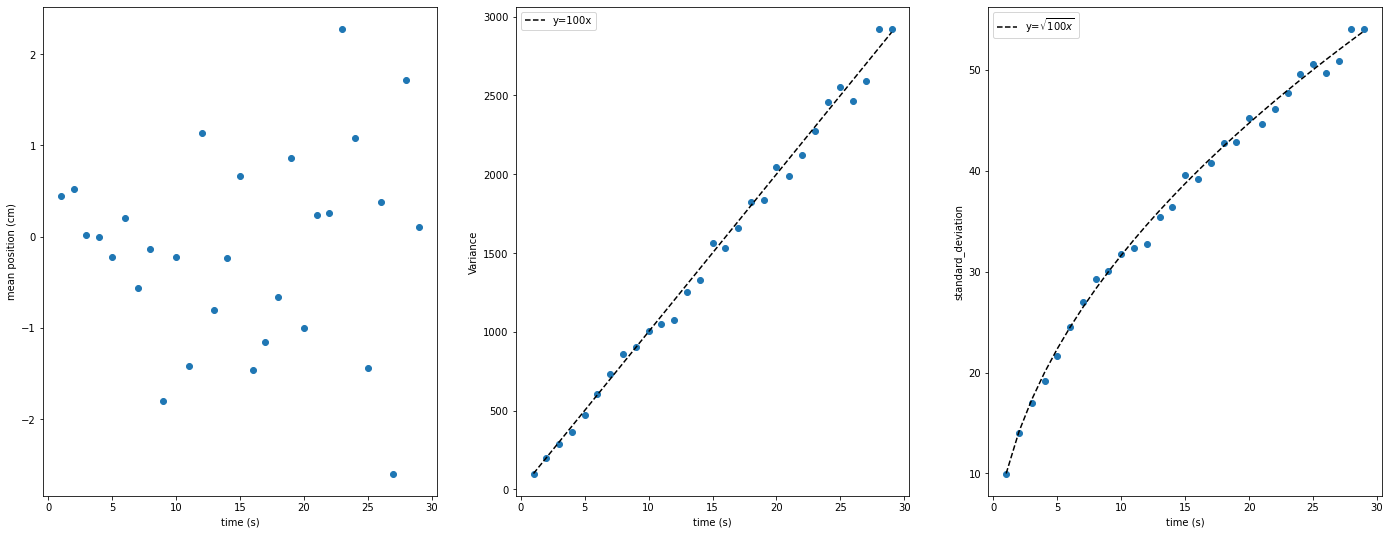

In [51]:
repeats = int(1e3)
timesteps = range(1, 30)
means, variances, standard_deviations = Ant1D.sim(repeats, timesteps)
# plot comparison of the sample statistics to the theoretical calculations we made in the md cell above
fig, ax = plt.subplots(1, 3, figsize=(24, 9))
ax[0].scatter(timesteps, means)
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("mean position (cm)")
ax[1].scatter(timesteps, variances)
# Remember we are working in units of 10cm, so variance will be in units of 10^2 = 100cm^2
ax[1].plot(
    timesteps,
    [t * 100 for t in timesteps],
    linestyle="dashed",
    color="k",
    label="y=100x",
)
ax[1].legend()
ax[1].set_xlabel("time (s)")
ax[1].set_ylabel("Variance")
ax[2].scatter(timesteps, standard_deviations)
# Again units of 10cm
ax[2].plot(
    timesteps,
    [10 * sqrt(t) for t in timesteps],
    label=r"y=$\sqrt{100x}$",
    linestyle="dashed",
    color="k",
)
ax[2].set_xlabel("time (s)")
ax[2].set_ylabel("standard_deviation")
ax[2].legend()
plt.show()

### The 1D problem
Now let's consider the one dimensional analogue to our two dimensional problem, what is the expectated number of timesteps for our ant to reach either +20cm or -20 cm? Clearly for reaching +/- 10cm this always happens on the first timestep. Let's consider the different permutations for timesteps and their associated probabilities. Clearly for n=1 the ant can never reach the food since they move at $10 ms^{-1}$. For the n=2 case we have 2 distinct permutations - moving in the same direction for the first 2 consecutive timesteps so $p(n=2) = 2 * \frac{1}{2^{2}} = \frac{1}{2}$. For the n=3 case we can see that we have zero probability. For the n=4 case we have 4 distinct permutations, moving initially in one direction and then either the opposite direction for the next 3 steps, or the opposite direction and then the initial direction for 2 consecutive steps. $p(n=4) = 4 * \frac{1}{2^{4}} = \frac{1}{4}$. We can rewrite this as $p(n=4) = \frac{1}{2} * p(n=2)$. Again for the n=5 case we can see that we have zero probability, in fact this is true for all odd n. For n=6 we can again see that there are 2 distinct branches for the first 2 moves (moving in one direction and then returning to the origin), before we arrive at the n=4 scenario: $p(n=6) = \frac{1}{2} * p(n=4) = \frac{1}{8}$. For even n we can generalise to $p(n) = \frac{1}{2^{\frac{n}{2}}}$. We can now write the expectation of n as $ E = \sum_{i=1}^{\infty} \frac{2i}{2^{i}} = 2\sum_{i=1}^{\infty} \frac{i}{2^{i}}$. Let's first check to see if this series converges using the ratio test: $|\lim_{n \to \infty} \frac{(n+1) \cdot 2^{n-1}}{n \cdot 2^{n}}| = |\lim_{n \to \infty} \frac{n+1}{2n}| = |\lim_{n \to \infty} \frac{1}{2} + \frac{1}{2n}| = \frac{1}{2} < 1$, therefore the series converges. To compute the sum, first explicitly write out a few terms: $S = \sum_{i=1}^{\infty} \frac{i}{2^{i}} = \frac{1}{2^1} + \frac{2}{2^2} +\frac{3}{2^3}+ \frac{4}{2^4} + ...$ $S = \sum_{i=1}^{\infty} \frac{1+0}{2^1} \frac{1+1}{2^2} + \frac{1+2}{2^3} + \frac{1+3}{2^4} = \sum_{i=1}^{\infty} \frac{1}{2^{i}} + \sum_{i=1}^{\infty} \frac{i}{2^{n+1}} = \sum_{i=1}^{\infty} \frac{1}{2^{i}} + \frac{1}{2} S$. We can simplify this to give an expression for S: $S = 2 \sum_{i=1}^{\infty} \frac{1}{2^{i}}$. Now we note the summation expression on the RHS is a simple geometric progression and totals 1. Hence we are left with $S = 2 \frac{\frac{1}{2}}{1-\frac{1}{2}} = 2 \implies E = 2S = 4$.
To compute the variance we again use $var(n) = E(n^{2}) - (E(n))^{2}$. $E(n^2) = 4 \sum_{i=1}^{\infty} \frac{i^2}{2^{i}} = 4 \cdot 6 = 24 \implies var(n) = 24 - 4^2 = 8 \implies \sigma(n) = \sqrt{8} = 2\sqrt{2}$

In [56]:
# Let's check with MC
import numpy as np

num_repeats = int(5e4)
ant = Ant1D()

trials = np.array([ant.time_to_food() for _ in range(num_repeats)])

mean = np.mean(trials)
variance = np.sum((trials - mean) ** 2) / num_repeats
standard_deviation = np.sqrt(variance)

print(f"{mean=}\n{variance=}\n{standard_deviation=}")

mean=4.02156
variance=8.1628151664
standard_deviation=2.857064081605451


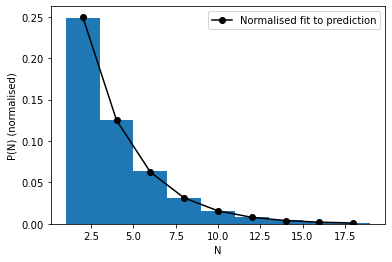

In [74]:
# check our calculation for P(n)

hist, bins, patches = plt.hist(trials, bins=np.arange(1, 20, 2), density=True)
centres = 0.5 * (bins[:-1] + bins[1:])
plt.plot(centres, [0.5 * 2 ** -(n/2) for n in centres], "-o", color="k", label="Normalised fit to prediction")
plt.legend()
plt.xlabel("N")
plt.ylabel("P(N) (normalised)")
plt.show()

### The 2D Problem

Here our ant is searching for food in 2 dimensions with food existing in a square around the origin. Again our ant moves at a speed of $10ms^{-1}$ but this time the ant can move up and down in the y direction as well as in the x direction. Having solved the first problem, we can frame our 2D problem as: What is E(n) such that |x| = 20 or |y| = 20? Here after 1 step we are at either (0, 10), (0, -10), (10, 0) or (-10, 0) with equal probality. Now P(n=2) is again simple to compute: $P(n=2) = 4 * \frac{1}{4^{2}} = \frac{1}{4}$. For the n=3 case we first consider the permutations of our ant finding itself in the 10x10 cm square centered at the origin. This is equal to the total possible paths after 2 steps (4 * 4 = 16) - the permutations that hit the 20x20 square boundary (previously calculated to be 4) - permutations for returning to the origin (also = 4 by symmetry) = 16 - 8 = 8. Note that for each n=2 permutation we are at the corners of our 10x10 square, hence there are 2 different way from each point to reach the 20x20 square boundary. Hence $P(n=3) = \frac{2 * 8}{4^3} = \frac{1}{4}$. For n=4 we again consider the permutations for lying on the boundary after n=3 steps. 


For the n=4 case we have 6 different path permutations for each initial position giving us 24 different permutations: we can first return to the origin and then take 2 consecutive steps in any of the 4 directions, or we first take a step perpendicular to the first step and then take a subsequent step in the first direction. Hence $P(n=4) = 24 * \frac{1}{4^4} = \frac{24}{256} = \frac{3}{32}$. For n=5 we have 



$P(A_n)$ = prob of being at $(0, 0)$ after n steps <br>
$P(B_n)$ = prob of being at $(\pm 10, 0)$ or $(0, \pm 10)$ after n steps <br>
$P(C_n)$ = prob of being at $(\pm 10,  \pm 10)$ after n steps <br>
$P(D_n)$ = prob of being at boundary (20 x 20 square) after n steps <br>

Now we note that: <br> 
$P(A_{n+1}) = \frac{1}{4} P(B_n) $ i.e. arrive at the origin we must be at $(\pm 10, 0)$ or $(0, \pm 10)$ at the previous step and there is $\frac{1}{4}$ prob of picking the correct direction for the final step<br>
$P(B_{n+1}) = P(A_n) + \frac{1}{2} P(C_n) $ i.e. at our penultimate step we must either be at the origin in which case any final step direction works or we are at $(\pm 10,  \pm 10)$ and have a $\frac{1}{2}$ prob of picking the correct final step direction <br>
$P(C_{n+1}) = \frac{1}{2} P(B_n) $ i.e. we must be at $(\pm 10, 0)$ or $(0, \pm 10)$ after the penultimate step and then have a $\frac{1}{2}$ probability of picking the correct final step direction <br>
$ P(D_{n+1}) = \frac{1}{2} P(C_n) + \frac{1}{4} P(B_n) $ i.e. we must be at $(\pm 10,  \pm 10)$ or $(\pm 10, 0)$ or $(0, \pm 10)$ after the penultimate step and have respective probabilities of $\frac{1}{2}$ and $\frac{1}{4}$ of picking the correct final step direction. <br>
Also note we have base cases $P(A_0) = 1$ and $P(B_1) = 1$, with $P(A_1) = P(B_0) = P(C_0) = P(D_0) = P(C_1) = P(D_1) = 0$ <br>


Now let's try to simplifiy the recursion relation for $P(D_{n})$: <br>
$P(D_n) = \frac{1}{2} P(C_{n-1}) + \frac{1}{4} P(B_{n-1}) = \frac{1}{4} P(B_{n-2}) + \frac{1}{4} P(B_{n-1})$ <br>
Now we note that $P(B_n) = P(A_{n-1}) + \frac{1}{2} P(C_{n-1}) = P(A_{n-1}) + \frac{1}{2} (\frac{1}{2} P(B_{n-2})) = P(A_{n-1}) + \frac{1}{4} P(B_{n-2})$

$P(2) = 4 * \frac{1}{4^2} = \frac{1}{4}$ <br>
$P(3) = 4 * 2 * 2 * \frac{1}{4^3} = \frac{16}{64} = \frac{1}{4}$


In [77]:
class Ant2D(AntBase):
    def move(self) -> None:
        choices = ((10, 0), (-10, 0), (0, 10), (0, -10))
        choice = self.rng.choice(choices)
        self.x += choice[0]
        self.y += choice[1]

    @property
    def at_food(self) -> bool:
        return abs(self.x) >= 20 or abs(self.y) >= 20

    def reset_coords(self) -> None:
        self.x = 0
        self.y = 0


ant = Ant2D()
num_repeats = int(1e4)
trials = np.array([ant.time_to_food() for _ in range(num_repeats)])

mean = np.mean(trials)
variance = np.sum((trials - mean) ** 2) / num_repeats
standard_deviation = np.sqrt(variance)

print(f"{mean=}\n{variance=}\n{standard_deviation=}")

mean=4.4732
variance=8.213281760000001
standard_deviation=2.865882370230851


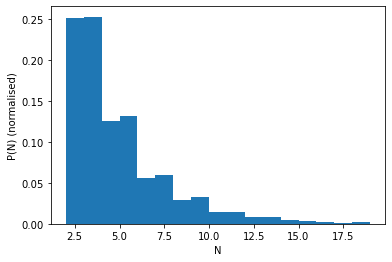

In [82]:
hist, bins, patches = plt.hist(trials, bins=np.arange(2, 20, 1), density=True)
centres = 0.5 * (bins[:-1] + bins[1:])
# plt.plot(centres, [0.5 * 2 ** -(n/2) for n in centres], "-o", color="k", label="Normalised fit to prediction")
# plt.legend()
plt.xlabel("N")
plt.ylabel("P(N) (normalised)")
plt.show()